<a href="https://colab.research.google.com/github/vedb1211/BookYourShow-Movieseat-Reservation-App/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:20<00:00, 32.5MB/s]
100% 612M/612M [00:20<00:00, 31.6MB/s]


In [3]:
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import random
from PIL import Image
import numpy as np

In [4]:
zip=zipfile.ZipFile('/content/gtsrb-german-traffic-sign.zip','r')
zip.extractall()
zip.close()

In [5]:
# Setting up necessary variables
train_path='/content/Train'
test_path='/content/Test'


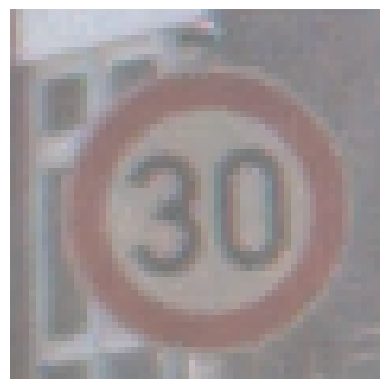

In [6]:
# Checking images from train dataset
image_path = '/content/Train/1/00001_00000_00003.png'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


(58, 58, 3)


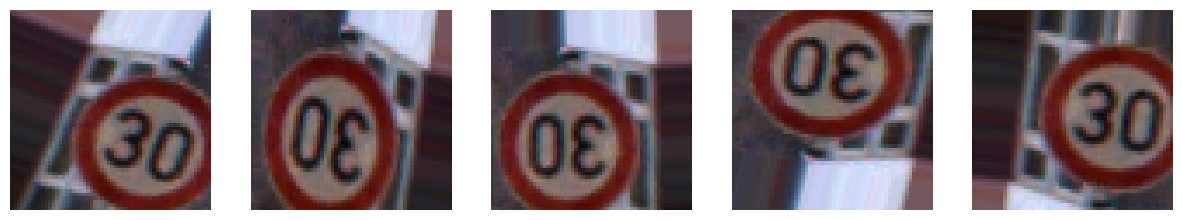

In [7]:

# getting the data from directory and performing data augmentation only on training data
train_datagen=ImageDataGenerator(
    rescale=1./255., # rescaling the images
    rotation_range=40, # rotating the image by 40 degrees
    width_shift_range=0.2, # shifting the image +-(20%) of original width
    height_shift_range=0.2, # shifting the image +-(20%) of original height
    shear_range=0.2, # shearing the image by 20% of image
    zoom_range=0.2, # zooming the image 20%
    validation_split=0.2,# splitting train data into train and validation set with 8:2 ratio
    horizontal_flip=True, # horizontaly flipping the image
    vertical_flip=True # vertically flipping the image
)
img = np.array(Image.open(image_path))
print(img.shape)
img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)

# Generate augmented images and display them
augmentations = 5  # Number of augmented images to generate
fig, axs = plt.subplots(1, augmentations, figsize=(15, 5))

for i, augmented_image in enumerate(train_datagen.flow(img, batch_size=1)):
    axs[i].imshow(array_to_img(augmented_image[0]))
    axs[i].axis('off')
    if i == augmentations - 1:
        break

plt.show()

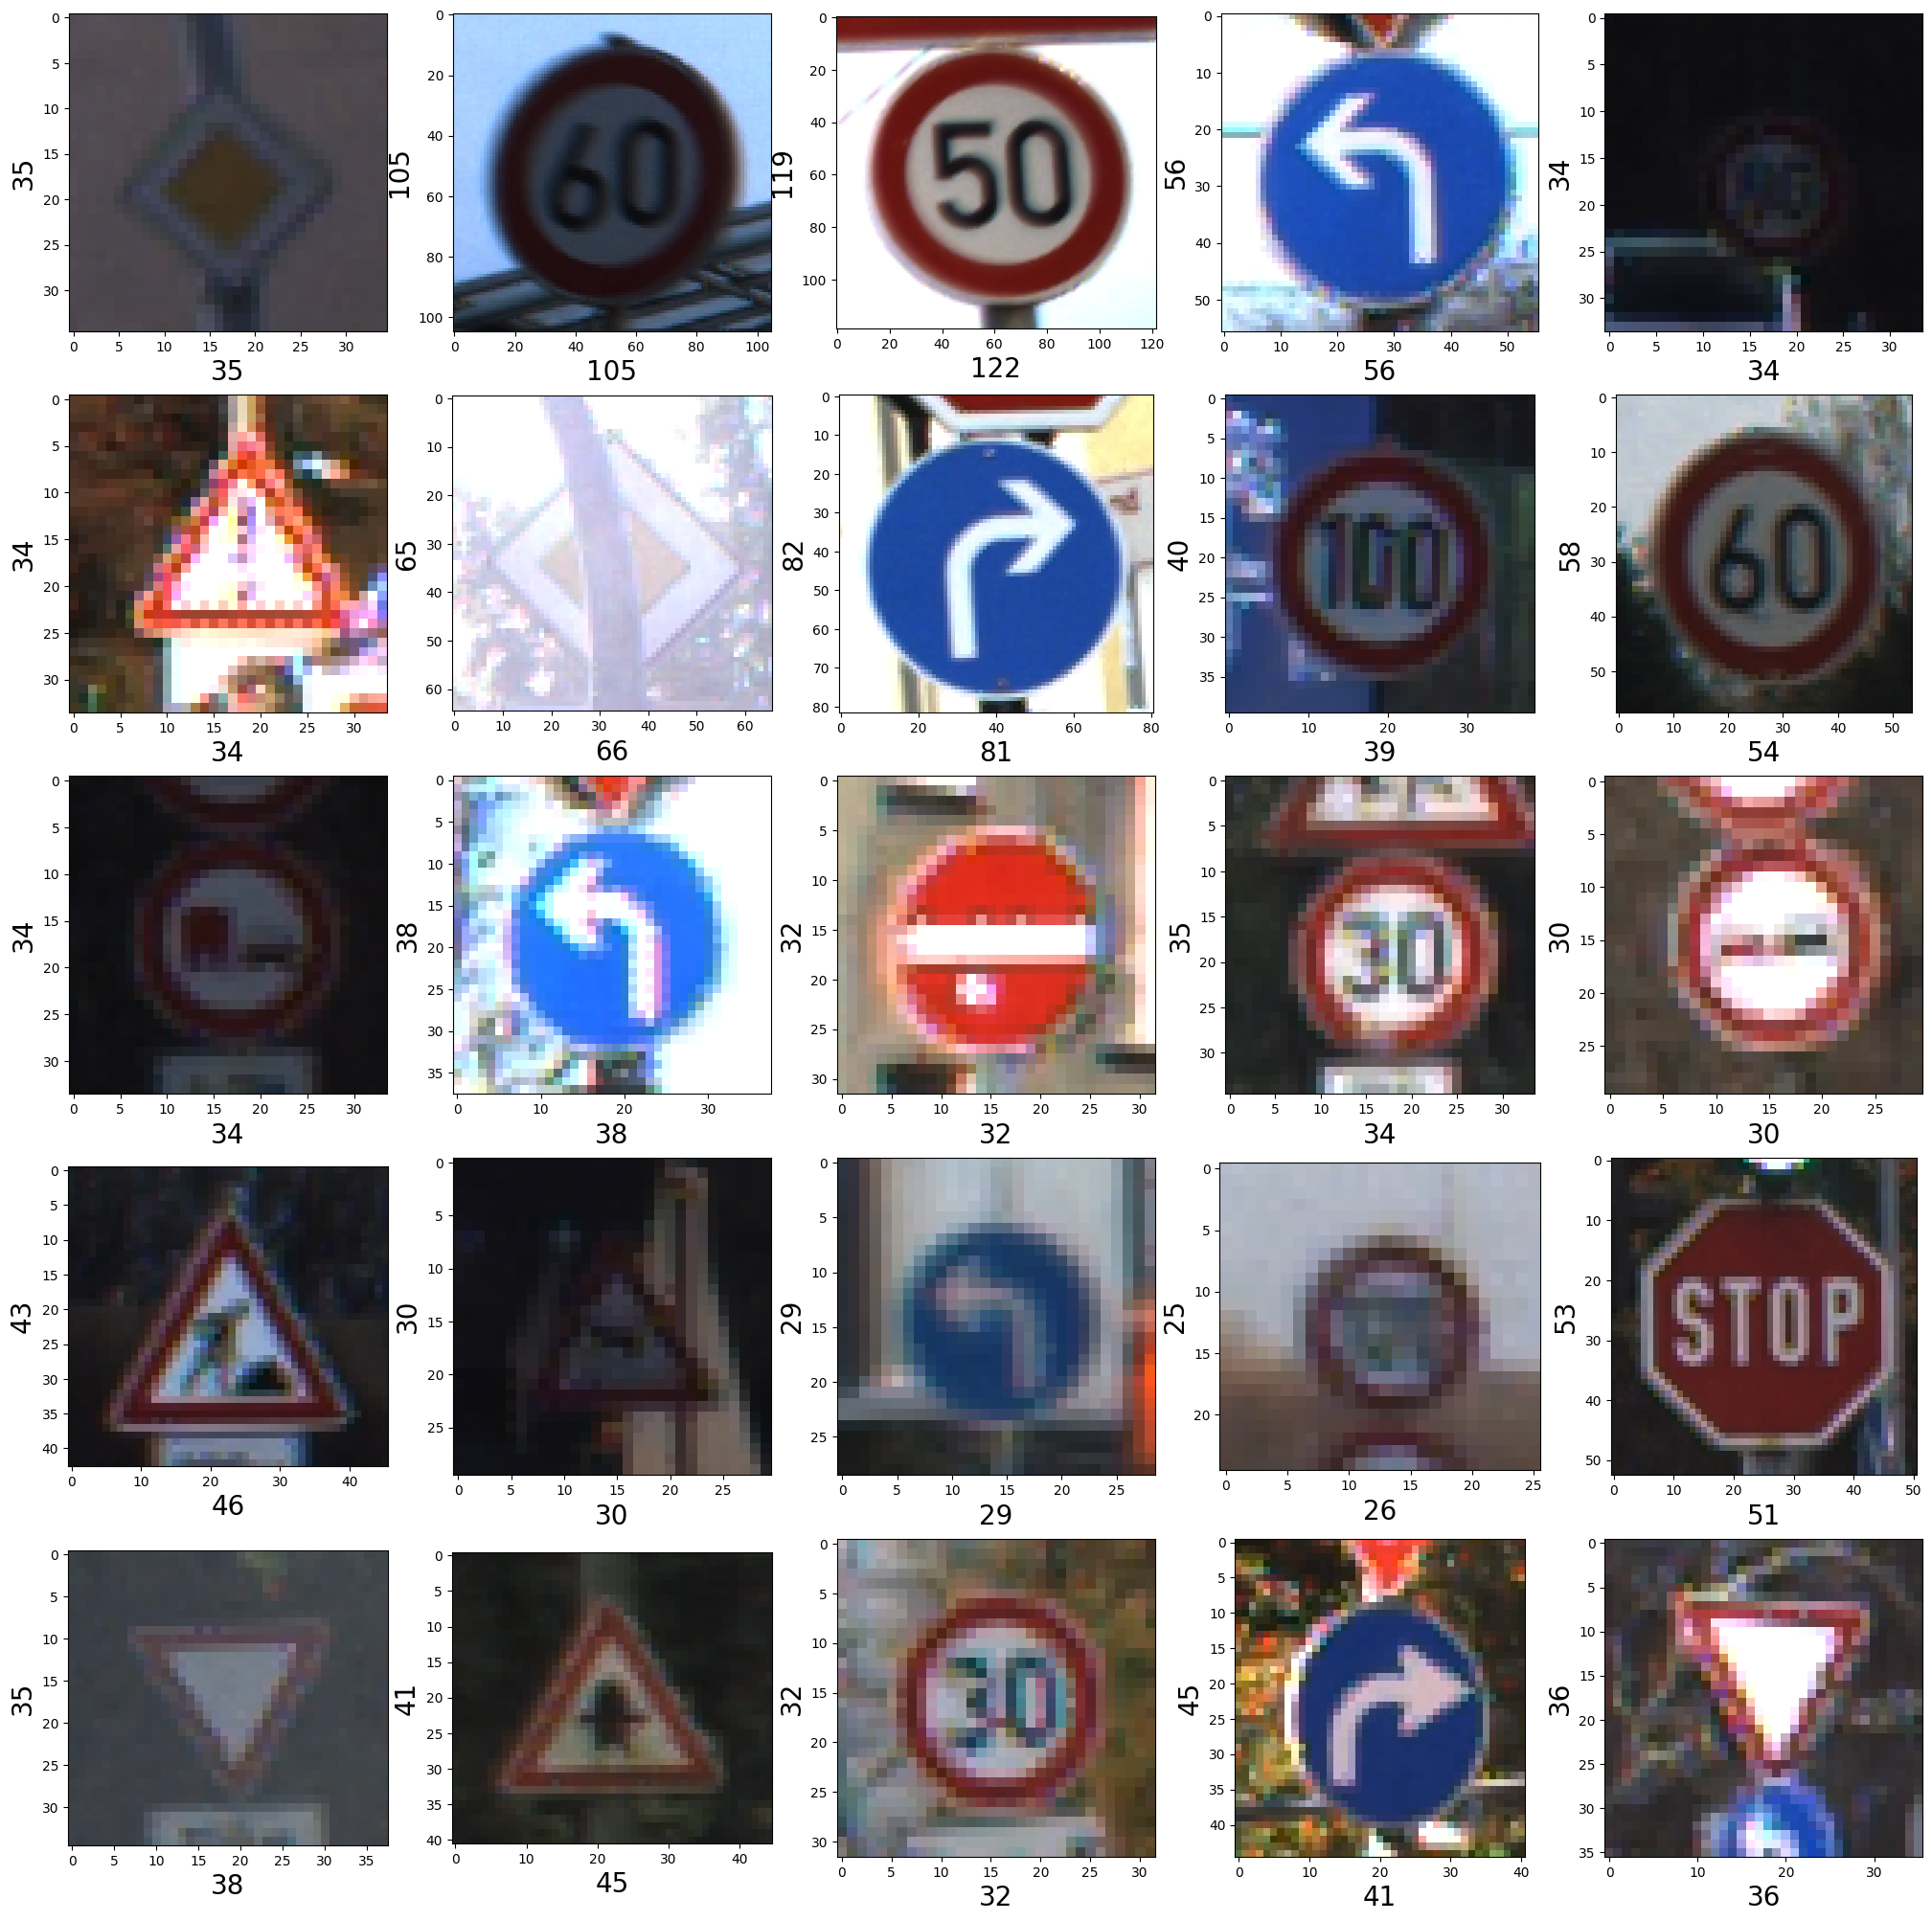

In [8]:
# Visualizing 25 random images from test data

import random
from matplotlib.image import imread

test = pd.read_csv('/content/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = '/content/' + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

The test data is not subgrouped into classes. Therefore, we have to create subfolders for the classes and move the image to the class subfolder.

In [9]:
import os
import pandas as pd
import shutil

# Path to the CSV file containing image paths and class labels
csv_file_path = '/content/Test.csv'  # Update with the correct path

# Root directory for the test dataset
test_data_root = '/content/Test'  # Update with the correct path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)
print(df.head(5))

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    image_path = str(row['Path'])  # Convert to string
    class_label = str(row['ClassId'])       # Convert to string

    # Create the subfolder for the class if it doesn't exist
    class_folder = os.path.join(test_data_root, class_label)
    os.makedirs(class_folder, exist_ok=True)

    # Move the image to the class subfolder
    image_filename = os.path.basename(image_path)
    destination_path = os.path.join(class_folder, image_filename)
    shutil.move(image_path, destination_path)

print("Test dataset subfolders created and images organized.")


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
Test dataset subfolders created and images organized.


In [10]:
# we do not need to augment the test data just rescale the data
test_datagen=ImageDataGenerator(rescale=1./255.)

In [11]:
# there are 43 classes and image size is 60X60
# creating three different data i.e. Train_data, Valid_data, Test_data
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150),
    subset='training'
)
val_data = train_datagen.flow_from_directory(
    train_path,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150),
    subset='validation'
)
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size = 128,
    class_mode = 'categorical',
    target_size = (150,150)
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [ ]:
# Create the model

input_shape=(150,150,3)

model1=tf.keras.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(3,activation='relu'),
    layers.Dense(43,activation='softmax')
],name='Model_1')


# compile model

model1.compile(optimizer = Adam(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = [CategoricalAccuracy(), Precision(), Recall()])
# Get the summary
model1.summary()

# Fit the model
history=model1.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10800)             0         
                                                                 
 dense (Dense)               (None, 3)                 32403     
                                                                 
 dense_1 (Dense)             (None, 43)                172       
                                                                 
Total params: 32575 (127.25 KB)
Trainable params: 32575 (127.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
246/246 [==============================] - 76s 284ms/step - loss: 3.5977 - categorical_accuracy: 0.0572 - precision: 0.0204 - recall: 6.3759e-05 - val_loss: 3.4889 - val_categorical_accuracy: 0.0566 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
246/246 [==

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

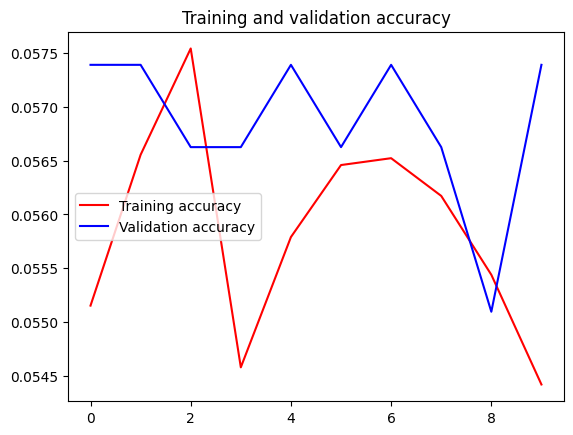

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

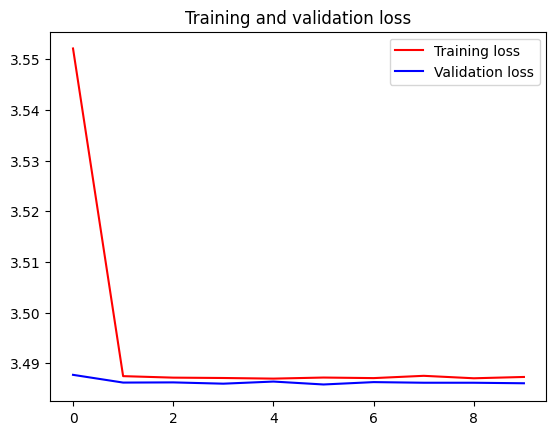

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss_1, accuracy_1, precision_1, recall_1 = model1.evaluate(test_data)
print('Loss of Model1 on test data: ',loss_1)
print('Accuracy of Model1 on test data: ',accuracy_1)
print('Precision of Model1 on test data: ',precision_1)
print('Recall of Model1 on test data: ',recall_1)


99/99 [==============================] - 6s 64ms/step - loss: 3.4636 - categorical_accuracy: 0.0594 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss of Model1 on test data:  3.463555335998535
Accuracy of Model1 on test data:  0.059382423758506775
Precision of Model1 on test data:  0.0
Recall of Model1 on test data:  0.0


In [16]:
model2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',input_shape = (150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(43,activation='softmax')

],name='Model_2')

# compile model

model2.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = [CategoricalAccuracy(), Precision(), Recall()])
# Get the summary
model2.summary()

# Fit the model
history=model2.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 17, 17, 32)        0   

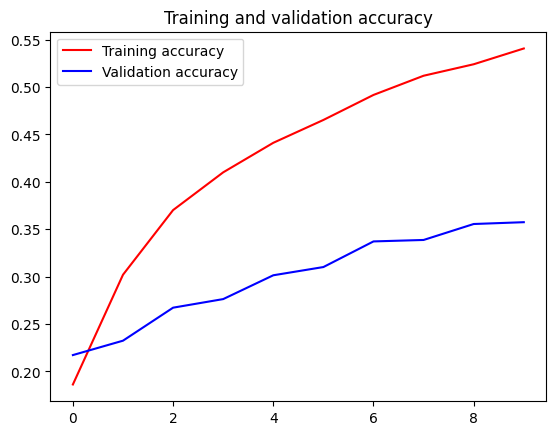

<Figure size 640x480 with 0 Axes>

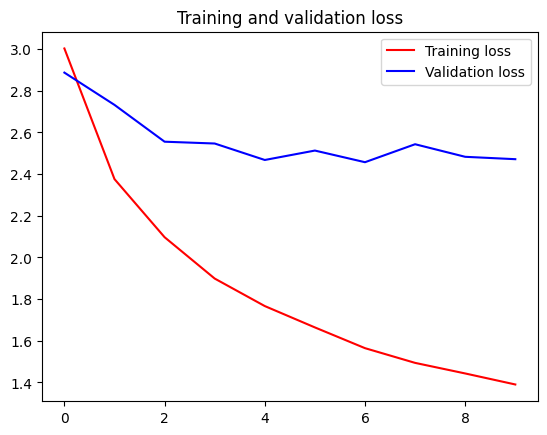

<Figure size 640x480 with 0 Axes>

99/99 [==============================] - 14s 144ms/step - loss: 1.7056 - categorical_accuracy: 0.4888 - precision_1: 0.6684 - recall_1: 0.3450
Loss of Model2 on test data:  1.705613374710083
Accuracy of Model2 on test data:  0.48875692486763
Precision of Model2 on test data:  0.6683540344238281
Recall of Model2 on test data:  0.34497228264808655


In [23]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

loss_2, accuracy_2, precision_2, recall_2 = model2.evaluate(test_data)

print('Loss of Model2 on test data: ',loss_2)
print('Accuracy of Model2 on test data: ',accuracy_2)
print('Precision of Model2 on test data: ',precision_2)
print('Recall of Model2 on test data: ',recall_2)


In [ ]:
# Using tensorflow to import the Inception model with pre-trained weights
inception_model=tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False)
inception_model.trainable=False # This causes the model not to train again on our dataset

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Taking inputs as 150X150X3 images and passing it through the Inception model and passing it to the Dense layer
inputs = layers.Input(shape=(150,150,3))
x = inception_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(43,activation="softmax")(x)
Tl_inception_model = Model(inputs,outputs)
Tl_inception_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 43)                88107     
                                                                 
Total params: 21890891 (83.51 MB)
Trainable params: 88107 (344.17 KB)
Non-trainable params: 21802784 (83.17 MB)
_____________

In [ ]:
# Compiling the Inception model with suitable loss and metrics
Tl_inception_model.compile(loss="categorical_crossentropy",
                optimizer="nadam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=Tl_inception_model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Epoch 1/10
246/246 [==============================] - 271s 1s/step - loss: 1.5270 - categorical_accuracy: 0.5423 - precision_5: 0.7910 - recall_5: 0.3326 - val_loss: 1.6279 - val_categorical_accuracy: 0.5138 - val_precision_5: 0.6999 - val_recall_5: 0.3487
Epoch 2/10
246/246 [==============================] - 289s 1s/step - loss: 1.1555 - categorical_accuracy: 0.6372 - precision_5: 0.8116 - recall_5: 0.4693 - val_loss: 1.5489 - val_categorical_accuracy: 0.5399 - val_precision_5: 0.7056 - val_recall_5: 0.4038
Epoch 3/10
246/246 [==============================] - 261s 1s/step - loss: 1.0339 - categorical_accuracy: 0.6723 - precision_5: 0.8249 - recall_5: 0.5251 - val_loss: 1.5297 - val_categorical_accuracy: 0.5516 - val_precision_5: 0.6982 - val_recall_5: 0.4323
Epoch 4/10
246/246 [==============================] - 255s 1s/step - loss: 0.9656 - categorical_accuracy: 0.6920 - precision_5: 0.8291 - recall_5: 0.5566 - val_loss: 1.4882 - val_categorical_accuracy: 0.5682 - val_precision_5: 0.

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

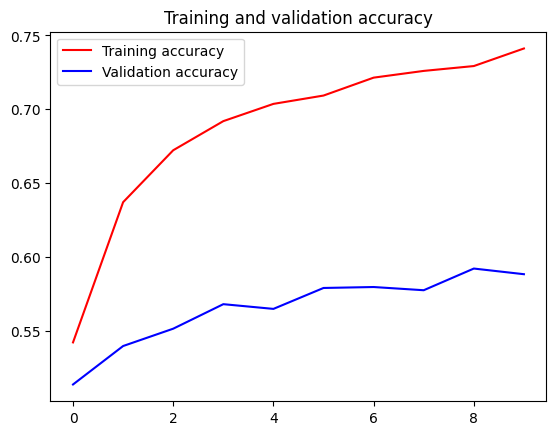

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
inception_loss,inception_accuracy, inception_precision, inception_recall = Tl_inception_model.evaluate(test_data)
print('Loss on test data: ',inception_loss)
print('Accuracy on test data: ',inception_accuracy)
print('Precision on test data: ',inception_precision)
print('Recall on test data: ',inception_recall)


99/99 [==============================] - 18s 175ms/step - loss: 1.1761 - categorical_accuracy: 0.6494 - precision_1: 0.7604 - recall_1: 0.5583
Loss on test data:  1.1760653257369995
Accuracy on test data:  0.6494061946868896
Precision on test data:  0.7603796124458313
Recall on test data:  0.55827397108078


In [ ]:
# Using tensorflow to import inception model along with pre-trained models
inception_model=tf.keras.applications.InceptionV3(input_shape=(100,100,3),include_top=False)
inception_model.trainable=False # this stops model to re-train the weights

In [ ]:
# Taking inputs as 100X100X3 images and passing it through the Inception model
# Adding new convolutional and dense layers to fine tune the model to our data
inputs = layers.Input(shape=(150,150,3))
x = inception_model(inputs)
x = layers.Conv2D(20,1,activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(10,activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43,activation="softmax")(x)
fine_tuned_inception_model = Model(inputs,outputs)
fine_tuned_inception_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 conv2d_192 (Conv2D)         (None, 3, 3, 20)          40980     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 20)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_188 (B  (None, 1, 1, 20)          80        
 atchNormalization)                                              
                                                                 
 flatten_3 (Flatten)         (None, 20)                0   

In [ ]:
# Compiling the fine tuned inception model with suitable loss and metrics
fine_tuned_inception_model.compile(loss="categorical_crossentropy",
                optimizer="nadam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=fine_tuned_inception_model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Epoch 1/10
246/246 [==============================] - 257s 1s/step - loss: 3.0199 - categorical_accuracy: 0.1839 - precision_6: 0.8294 - recall_6: 0.0256 - val_loss: 2.3577 - val_categorical_accuracy: 0.3261 - val_precision_6: 0.9482 - val_recall_6: 0.0467
Epoch 2/10
246/246 [==============================] - 247s 1s/step - loss: 2.3476 - categorical_accuracy: 0.2952 - precision_6: 0.7742 - recall_6: 0.0939 - val_loss: 2.0164 - val_categorical_accuracy: 0.3807 - val_precision_6: 0.8371 - val_recall_6: 0.1455
Epoch 3/10
246/246 [==============================] - 249s 1s/step - loss: 2.1480 - categorical_accuracy: 0.3329 - precision_6: 0.7842 - recall_6: 0.1299 - val_loss: 1.8623 - val_categorical_accuracy: 0.4290 - val_precision_6: 0.8777 - val_recall_6: 0.1683
Epoch 4/10
246/246 [==============================] - 244s 992ms/step - loss: 2.0423 - categorical_accuracy: 0.3550 - precision_6: 0.7988 - recall_6: 0.1518 - val_loss: 1.7834 - val_categorical_accuracy: 0.4374 - val_precision_6:

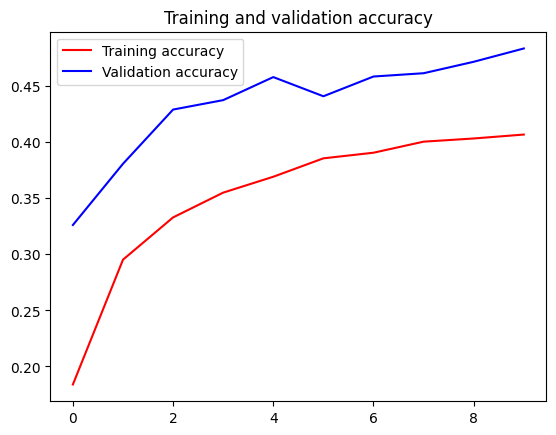

<Figure size 640x480 with 0 Axes>

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

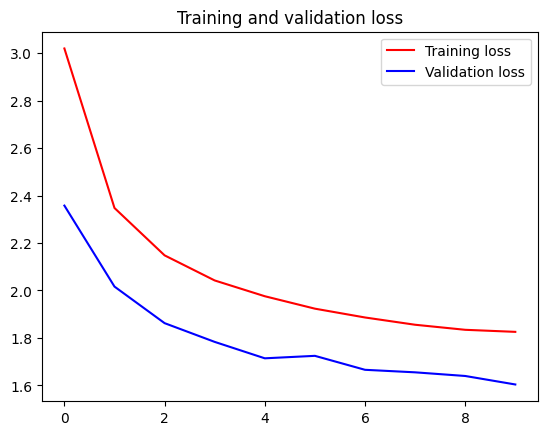

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Printing the metrics of the fine tuned Inception model tested on test_data
fine_tuned_inception_loss, fine_tuned_inception_accuracy, fine_tuned_inception_precision, fine_tuned_inception_recall = fine_tuned_inception_model.evaluate(test_data)
print('Loss on test data: ',fine_tuned_inception_loss)
print('Accuracy on test data: ',fine_tuned_inception_accuracy)
print('Precision on test data: ',fine_tuned_inception_precision)
print('Recall on test data: ',fine_tuned_inception_recall)

99/99 [==============================] - 20s 198ms/step - loss: 1.4460 - categorical_accuracy: 0.5345 - precision_6: 0.8550 - recall_6: 0.2852
Loss on test data:  1.446015477180481
Accuracy on test data:  0.5345209836959839
Precision on test data:  0.8549727201461792
Recall on test data:  0.2851939797401428


In [12]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding="same"),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=43, activation="softmax")
],name = 'model3')

model3.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = [CategoricalAccuracy(), Precision(), Recall()])
# Get the summary
model3.summary()

# Fit the model
history=model3.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)


Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464

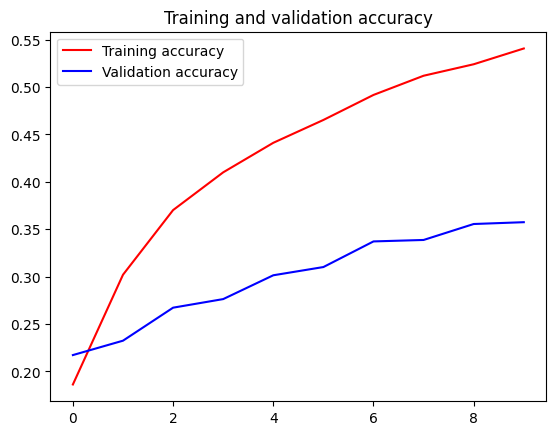

<Figure size 640x480 with 0 Axes>

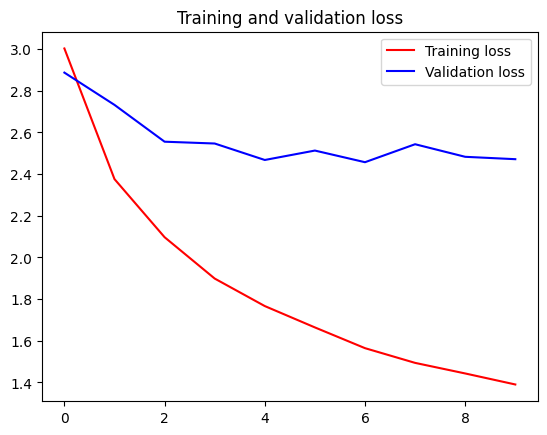

<Figure size 640x480 with 0 Axes>

99/99 [==============================] - 16s 163ms/step - loss: 2.0624 - categorical_accuracy: 0.3902 - precision: 0.6083 - recall: 0.2587
Loss on test data:  2.062420606613159
Accuracy on test data:  0.39018210768699646
Precision on test data:  0.6083395481109619
Recall on test data:  0.25874900817871094


In [22]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Printing the metrics of the fine tuned Inception model tested on test_data
regularised_CNN_loss, regularised_CNN_accuracy, regularised_CNN_precision, regularised_CNN_recall = model3.evaluate(test_data)
print('Loss on test data: ',regularised_CNN_loss)
print('Accuracy on test data: ',regularised_CNN_accuracy)
print('Precision on test data: ',regularised_CNN_precision)
print('Recall on test data: ',regularised_CNN_recall)

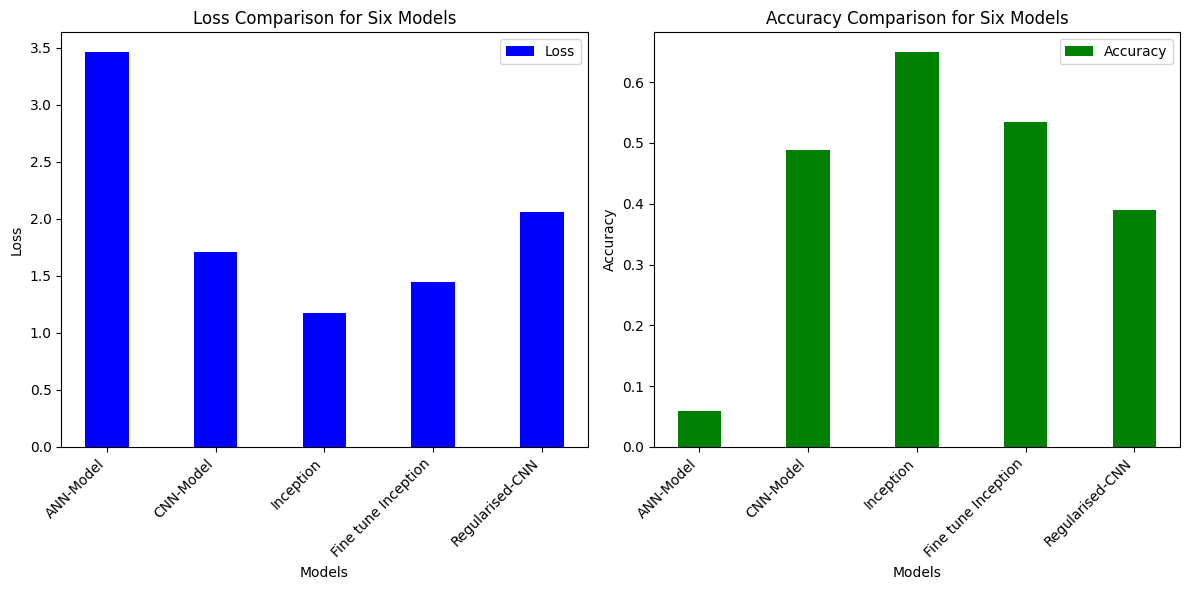

In [21]:
# Model names or labels
model_names = ['ANN-Model', 'CNN-Model', 'Inception', 'Fine tune Inception', 'Regularised-CNN']


# Metrics data
loss = [3.46355, 1.7056130, 1.176065, 1.446015, 2.062420]
accuracy = [0.05938, 0.48875, 0.64940, 0.534520, 0.39018210]

# Set the width of the bars
bar_width = 0.4

# Set the position of each bar on the x-axis
index = np.arange(len(model_names))

# Create subplots with a larger figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss on the first subplot
ax1.bar(index, loss, bar_width, label='Loss', color='blue')
ax1.set_xticks(index)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_xlabel('Models')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Comparison for Six Models')
ax1.legend()

# Plot accuracy on the second subplot
ax2.bar(index, accuracy, bar_width, label='Accuracy', color='green')
ax2.set_xticks(index)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Comparison for Six Models')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
